In [6]:
pip install alpha_vantage pandas numpy scikit-learn matplotlib tensorflow



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
from alpha_vantage.timeseries import TimeSeries

# Alpha Vantage API key
api_key = '5FPGYXJ7ZWJOWKH3'

# Initialize TimeSeries with your API key
ts = TimeSeries(key=api_key, output_format='pandas')

# Fetch daily stock prices (e.g., for Apple)
ticker = 'AAPL'
data, meta_data = ts.get_daily(symbol=ticker, outputsize='full')

# Save data to CSV
data.to_csv(f'{ticker}_daily.csv')


In [8]:
display(data)

,1. open,2. high,3. low,4. close,5. volume
date,,,,,
2024-11-13,224.010,226.650,222.760,225.12,47701084.0
2024-11-12,224.550,225.590,223.355,224.23,40398299.0
2024-11-11,225.000,225.700,221.500,224.23,42005602.0
2024-11-08,227.170,228.660,226.405,226.96,38328824.0
2024-11-07,224.625,227.875,224.570,227.48,42137691.0
...,...,...,...,...,...
1999-11-05,84.620,88.370,84.000,88.31,3721500.0
1999-11-04,82.060,85.370,80.620,83.62,3384700.0
1999-11-03,81.620,83.250,81.000,81.50,2932700.0


In [9]:
# Load the data
data = pd.read_csv(f'{ticker}_daily.csv', index_col='date', parse_dates=True)

# Select relevant columns (closing price)
data = data[['4. close']]
data.columns = ['Close']

# Create technical indicators
data['MA20'] = data['Close'].rolling(window=20).mean()
data['MA50'] = data['Close'].rolling(window=50).mean()

# Drop rows with NaN values (due to moving averages)
data = data.dropna()

# Split the data
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]


Matplotlib is building the font cache; this may take a moment.


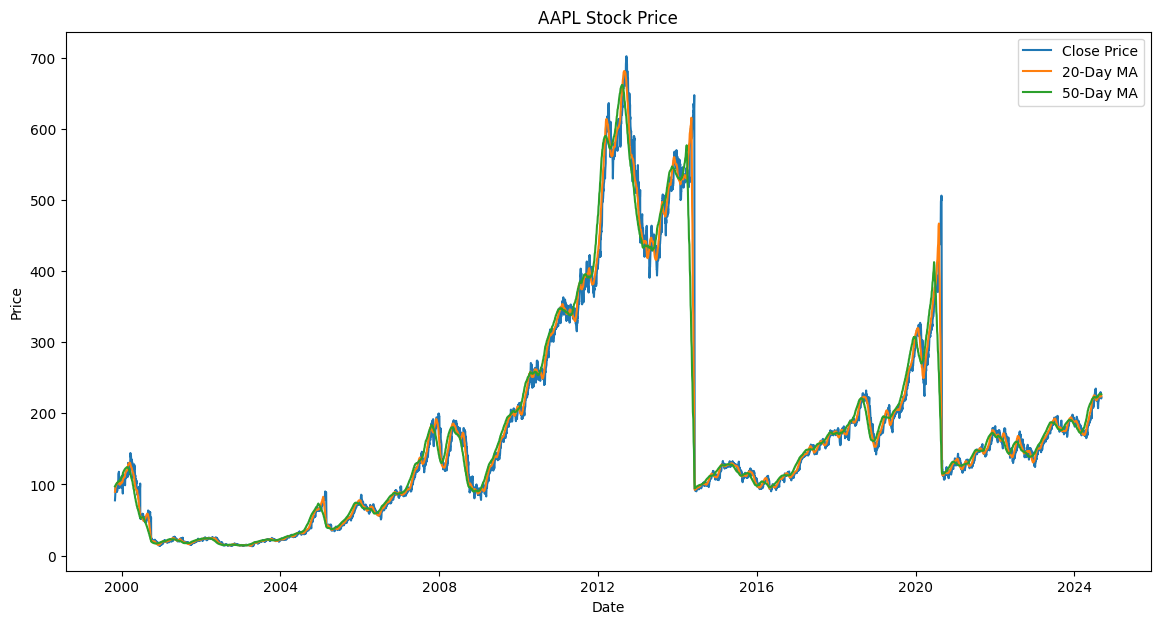

In [10]:
import matplotlib.pyplot as plt

# Plot Close price and Moving Averages
plt.figure(figsize=(14, 7))
plt.plot(data['Close'], label='Close Price')
plt.plot(data['MA20'], label='20-Day MA')
plt.plot(data['MA50'], label='50-Day MA')
plt.title(f'{ticker} Stock Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


155/155 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.0206
Epoch 2/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0011
Epoch 3/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 9.0750e-04
Epoch 4/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 6.2611e-04
Epoch 5/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 8.6346e-04
Epoch 6/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 7.4452e-04
Epoch 7/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 5.6536e-04
Epoch 8/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 7.0540e-04
Epoch 9/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 4.4027e-04
Epoch 10/10
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 6.3009e-04
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


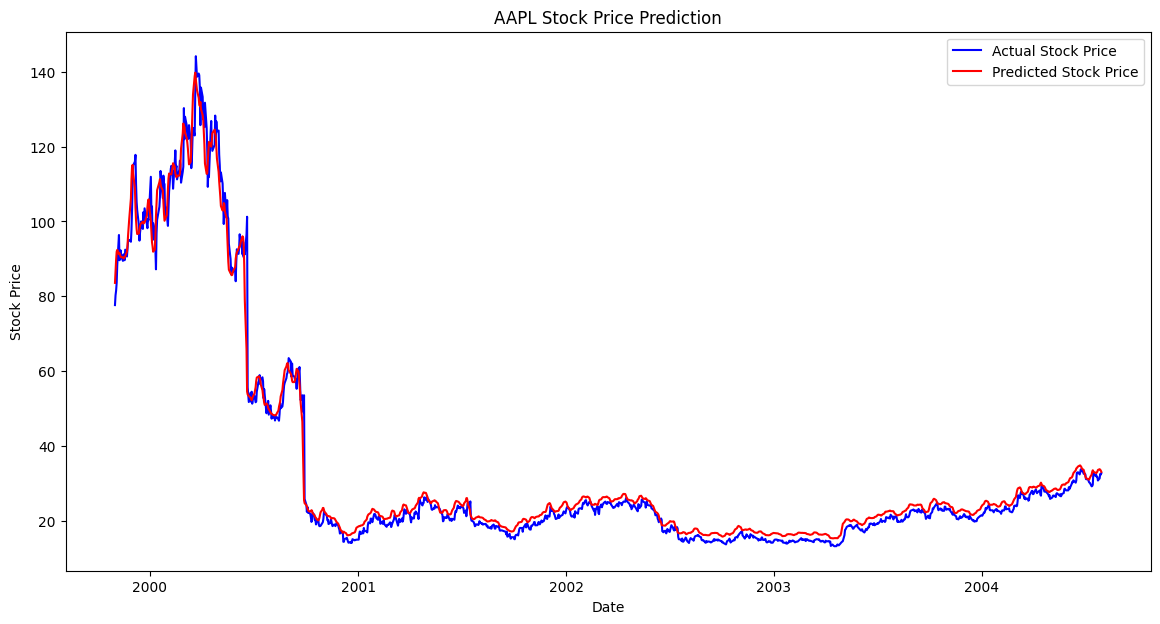

In [11]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

# Scale the 'Close' data only for the training set
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train[['Close']])

# Prepare data for LSTM (look-back window)
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back, 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

# Use the Close column only for LSTM input
look_back = 60
X_train, y_train = create_dataset(train_scaled, look_back)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

# Build and train the LSTM model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Scale test data for prediction
test_scaled = scaler.transform(test[['Close']])
X_test, y_test = create_dataset(test_scaled, look_back)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Predict and inverse transform only on the Close column
predicted_stock_price = model.predict(X_test)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)  # This should now work as expected

# Plot predictions vs actual prices
plt.figure(figsize=(14, 7))
plt.plot(test.index[look_back:], test['Close'][look_back:], color='blue', label='Actual Stock Price')
plt.plot(test.index[look_back:], predicted_stock_price, color='red', label='Predicted Stock Price')
plt.title(f'{ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [12]:
import joblib

# Save model and scaler
model.save('lstm_stock_model.h5')
joblib.dump(scaler, 'scaler.save')


['scaler.save']

In [17]:
%pip install ta

  Using cached ta-0.11.0.tar.gz (25 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=640a2fb116b55848e95ed937374fa0727d5c4f2ee8fbc257c880075208f5f1e6
  Stored in directory: /Users/harshithajonnalagadda/Library/Caches/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [18]:
import ta
data, _ = ts.get_daily(symbol=ticker, outputsize='full')
data.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

# Adding Moving Averages
data['MA20'] = data['Close'].rolling(window=20).mean()
data['MA50'] = data['Close'].rolling(window=50).mean()

# Adding Relative Strength Index (RSI)
data['RSI'] = ta.momentum.RSIIndicator(data['Close'], window=14).rsi()

# Adding MACD
data['MACD'] = ta.trend.MACD(data['Close']).macd()

# Dropping NA values from new features
data = data.dropna()

In [19]:
%pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.0 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [20]:
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Setting up a distribution strategy for multi-GPU support if available
strategy = tf.distribute.MirroredStrategy()

# Define the model with a reduced range of hyperparameters and GRU instead of LSTM
def build_model(hp):
    model = Sequential()
    model.add(GRU(
        units=hp.Int('units', min_value=64, max_value=128, step=32),
        return_sequences=True,
        input_shape=(X_train.shape[1], 1)
    ))
    model.add(GRU(units=hp.Int('units', min_value=32, max_value=64, step=32)))
    model.add(Dense(1))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', [1e-3, 5e-4])),
        loss='mean_squared_error'
    )
    return model

# Initialize the tuner with fewer trials and executions per trial, within the strategy scope
with strategy.scope():
    tuner = RandomSearch(
        build_model,
        objective='val_loss',
        max_trials=3,               # Reduced from 5 to 3 for faster tuning
        executions_per_trial=1,      # Only 1 execution per trial
        directory='tuner',
        project_name='stock_price_prediction'
    )

# Set up Early Stopping to halt early if no improvement
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Optionally, train on a sample of the data for faster tuning
X_train_sample = X_train[:int(len(X_train) * 0.5)]
y_train_sample = y_train[:int(len(y_train) * 0.5)]

# Perform the hyperparameter search with early stopping
tuner.search(
    X_train_sample, y_train_sample,
    epochs=5,                     # Reduced epochs for quicker training
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

# Print the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Optimal number of units: {best_hps.get('units')}")
print(f"Optimal learning rate: {best_hps.get('learning_rate')}")


Trial 3 Complete [00h 00m 13s]
val_loss: 1.4420605111808982e-05

Best val_loss So Far: 1.239767334482167e-05
Total elapsed time: 00h 00m 36s
Optimal number of units: 96
Optimal learning rate: 0.001


In [21]:
best_model = tuner.get_best_models(num_models=1)[0]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [25]:
pip install statsmodels


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 12.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.9/232.9 kB 13.0 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has bee

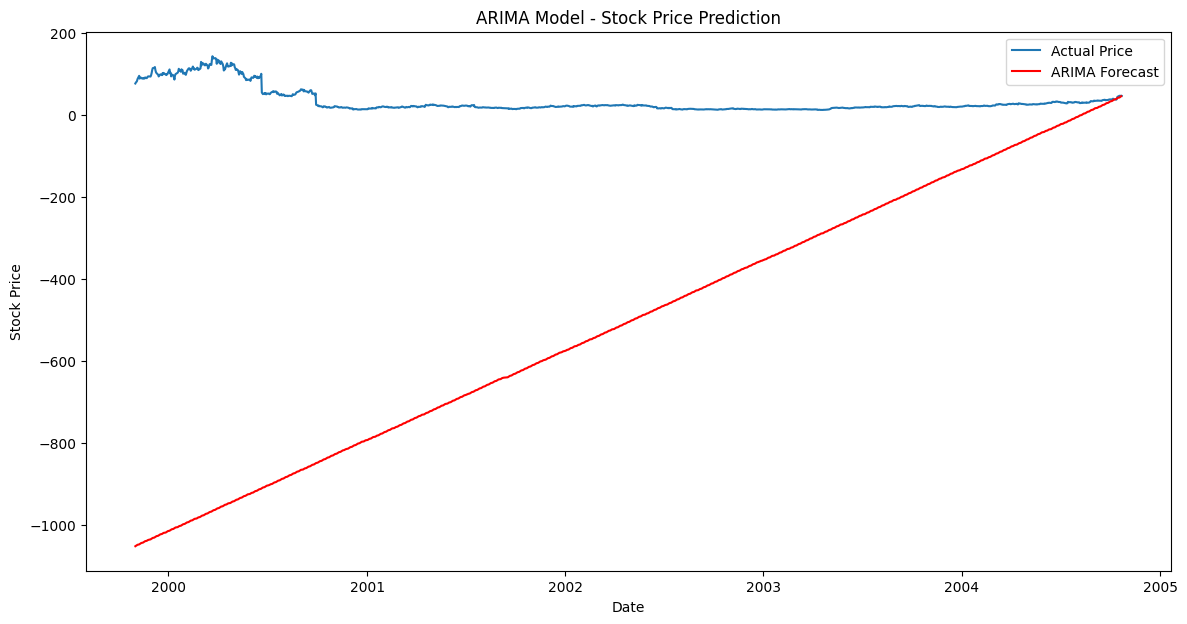

In [26]:
from statsmodels.tsa.arima.model import ARIMA  

# Differencing data for stationarity (necessary for ARIMA)
data_diff = data['Close'].diff().dropna()

# Train-test split
train_size = int(len(data_diff) * 0.8)
train_arima, test_arima = data_diff[:train_size], data_diff[train_size:]

# Fit the ARIMA model (tune order (p, d, q) based on AIC score or grid search)
model = ARIMA(train_arima, order=(5, 1, 0))
arima_model = model.fit()

# Forecast on the test set
forecast = arima_model.forecast(steps=len(test_arima))

# Restore original scale by adding the last observed value
forecast = pd.Series(forecast).cumsum() + data['Close'].iloc[train_size]

# Plotting ARIMA predictions vs actual prices
plt.figure(figsize=(14, 7))
plt.plot(data.index[train_size:], data['Close'].iloc[train_size:], label='Actual Price')

# Ensure that `forecast` aligns with the index of `data`
plt.plot(data.index[train_size+1:], forecast, color='red', label='ARIMA Forecast')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('ARIMA Model - Stock Price Prediction')
plt.legend()
plt.show()

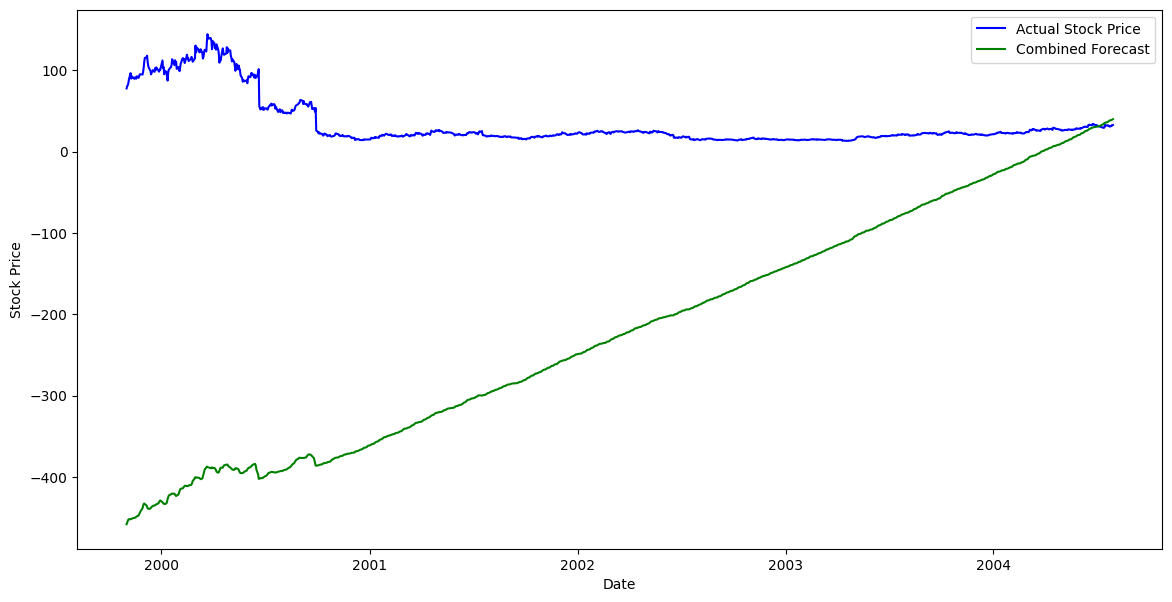

In [27]:
# Assume `lstm_predicted` is from LSTM and `arima_forecast` is from ARIMA
# Get the minimum length of the two arrays to ensure compatibility
min_len = min(predicted_stock_price.flatten().shape[0], forecast.values.shape[0])

# Slice both arrays to the minimum length before performing the operation
combined_forecast = (predicted_stock_price.flatten()[:min_len] + forecast.values[:min_len]) / 2

# Plotting combined predictions
plt.figure(figsize=(14, 7))

# Adjust the x-axis for plotting based on the sliced data
plt.plot(test.index[look_back:look_back + min_len], test['Close'][look_back:look_back + min_len], color='blue', label='Actual Stock Price')
plt.plot(test.index[look_back:look_back + min_len], combined_forecast, color='green', label='Combined Forecast')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [28]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Trim the forecast to match the length of test data after look_back
adjusted_forecast = forecast[:len(test['Close']) - look_back]

# Compute MAE and MSE on the aligned data
mae_arima = mean_absolute_error(test['Close'][look_back:], adjusted_forecast)
mse_arima = mean_squared_error(test['Close'][look_back:], adjusted_forecast)

print("ARIMA Model - Mean Absolute Error (MAE):", mae_arima)
print("ARIMA Model - Mean Squared Error (MSE):", mse_arima)


ARIMA Model - Mean Absolute Error (MAE): 510.92842691583553
ARIMA Model - Mean Squared Error (MSE): 364483.058906012


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pickle

# Ensure both predicted_stock_price and forecast align with test data
# Adjust forecast and LSTM predictions if necessary to match lengths
adjusted_predicted_stock_price = predicted_stock_price[:len(test['Close']) - look_back]
adjusted_forecast = forecast[:len(test['Close']) - look_back]

# Evaluate LSTM model
mae_lstm = mean_absolute_error(test['Close'][look_back:], adjusted_predicted_stock_price)
mse_lstm = mean_squared_error(test['Close'][look_back:], adjusted_predicted_stock_price)

# Evaluate ARIMA model
mae_arima = mean_absolute_error(test['Close'][look_back:], adjusted_forecast)
mse_arima = mean_squared_error(test['Close'][look_back:], adjusted_forecast)

# Print evaluation results
print(f"LSTM MAE: {mae_lstm}, MSE: {mse_lstm}")
print(f"ARIMA MAE: {mae_arima}, MSE: {mse_arima}")

# Save the best model based on the evaluation
if mae_lstm < mae_arima:
    best_model.save('best_stock_model.h5')
    print("LSTM model saved as best_stock_model.h5")
else:
    # Save the ARIMA model using pickle
    with open('best_stock_model_arima.pkl', 'wb') as f:
        pickle.dump(arima_model, f)
    print("ARIMA model saved as best_stock_model_arima.pkl")


LSTM MAE: 5.346027020760768, MSE: 33.503295612405786
ARIMA MAE: 510.92842689684494, MSE: 364483.05887959927
LSTM model saved as best_stock_model.h5
